In [5]:
import os
import json
import csv
from glob import glob

# Define the directory and file pattern
# path = "F:/setup files/downloads/Result2/"
path = "F:/setup files/downloads/Finetune/"
file_pattern = os.path.join(path, "*.json")

# List of files matching our pattern
files = glob(file_pattern)

# Prepare a list to store results
results = []

# Loop through each JSON file
for filename in files:
    # Load JSON data
    with open(filename, 'r') as f:
        data = json.load(f)

    # Determine number of objectives using the first algorithm/generation/solution
    # (Assuming at least one algorithm, one generation, and one individual exist)
    sample_alg = next(iter(data))
    sample_gen = next(iter(data[sample_alg]))
    sample_solution = data[sample_alg][sample_gen][0]
    objectives_count = len(sample_solution)

    # Initialize nadir point with very small values
    nadir = [-float('inf')] * objectives_count

    # Iterate over all algorithms, generations, and individuals to compute nadir
    for algorithm in data:
        for generation in range(1,101):
            # print(algorithm, generation)
            for individual in data[algorithm][str(generation)]:
                # Update nadir for each objective dimension
                for idx, value in enumerate(individual):
                    if value > nadir[idx]:
                        nadir[idx] = value

    # Store filename (or parsed info) and computed nadir point
    base_filename = os.path.basename(filename)
    result_row = {"file": base_filename}
    # Add each objective's nadir value to the row
    for j in range(objectives_count):
        result_row[f"obj_{j+1}_nadir"] = nadir[j]

    results.append(result_row)

# Define CSV fieldnames based on objectives count
fieldnames = ["file"] + [f"obj_{j+1}_nadir" for j in range(objectives_count)]

# Write results to a CSV file
output_csv = os.path.join(path, "nadir_points.csv")
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)

print(f"Nadir points saved to {output_csv}")

Nadir points saved to F:/setup files/downloads/Finetune/nadir_points.csv


In [6]:
import os
import json
import glob
import pandas as pd
import numpy as np
from pymoo.indicators.hv import HV

def cal_hv(front, ref_point):
    with np.errstate(divide='ignore', invalid='ignore'):
        scaled_front = np.divide(front, ref_point, out=np.zeros_like(front), where=ref_point!=0)
    scaled_ref_point = np.ones_like(ref_point)
    hv_indicator = HV(ref_point=scaled_ref_point)
    return hv_indicator(scaled_front)

# Settings
base_path = "F:/setup files/downloads/Finetune/"
nadir_csv_path = os.path.join(base_path, "nadir_points.csv")

# Load the nadir points CSV
nadir_df = pd.read_csv(nadir_csv_path)

# Define generation range from 0 to 150
generation_steps = range(0, 101)  # 0 to 150

# Choose problem types or adapt as needed
problem_types = [200, 400, 800]

params = [3,5,8,10]

for prob_type in problem_types:
    for param in params:
        # Adjust file pattern as needed based on naming convention
        file_pattern = os.path.join(base_path, f"*_{prob_type//100}_*_0_{param}.json")
        files = glob.glob(file_pattern)
        
        if not files:
            print(f"No files found for problem type {prob_type}.")
            continue

        # Dictionary to store HV trends: {algorithm: {generation: [HV values across files]}}
        hv_trends = {}

        for file_path in files:
            file_name = os.path.basename(file_path)

            # Retrieve corresponding nadir row
            nadir_row = nadir_df[nadir_df['file'] == file_name]
            if nadir_row.empty:
                print(f"Nadir info not found for {file_name}. Skipping.")
                continue
            nadir_row = nadir_row.iloc[0]

            # Extract nadir point for scaling
            obj_columns = sorted(
                [col for col in nadir_df.columns if col.startswith("obj_") and col.endswith("_nadir")],
                key=lambda x: int(x.split('_')[1])
            )
            nadir_point = np.array([nadir_row[col] for col in obj_columns])

            # Load JSON data from file
            with open(file_path, 'r') as f:
                data = json.load(f)

            # Iterate over algorithms in the JSON data
            for algorithm in data:
                # Initialize hv_trends for algorithm if not present
                if algorithm not in hv_trends:
                    hv_trends[algorithm] = {gen: [] for gen in generation_steps}

                # Loop through generations 0 to 150
                for gen in generation_steps:
                    gen_key = str(gen)
                    if gen_key not in data[algorithm]:
                        # Skip if generation data is missing
                        continue

                    solutions = data[algorithm][gen_key]
                    solutions_np = np.array(solutions)

                    if solutions_np.size == 0:
                        continue

                    try:
                        hv_value = cal_hv(solutions_np, nadir_point)
                    except Exception as e:
                        print(f"Error computing HV for {algorithm} at generation {gen} in {file_name}: {e}")
                        continue

                    hv_trends[algorithm][gen].append(hv_value)

        # Compute average HV per generation across files for each algorithm
        avg_hv_trends = {}
        for algorithm, gen_dict in hv_trends.items():
            avg_hv_trends[algorithm] = {
                gen: np.mean(hv_list) if hv_list else np.nan 
                for gen, hv_list in gen_dict.items()
            }

        # Convert the average HV trends into a DataFrame and save to CSV
        df_avg_hv = pd.DataFrame(avg_hv_trends)
        csv_filename = os.path.join(base_path, f"Avg_HV_Trends_Type_{prob_type//100}_param_{param}.csv")
        df_avg_hv.to_csv(csv_filename, index_label='Generation')
        print(f"Average HV trends saved to {csv_filename}")

        # If you only want to process the first problem type, uncomment the next line:
        # break

Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_2_param_3.csv
Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_2_param_5.csv
Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_2_param_8.csv
Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_2_param_10.csv
Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_4_param_3.csv
Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_4_param_5.csv
Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_4_param_8.csv
Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_4_param_10.csv
Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_8_param_3.csv
Average HV trends saved to F:/setup files/downloads/Finetune/Avg_HV_Trends_Type_8_param_5.csv
Average HV trends saved to F:/setup files/downloads/Finetu

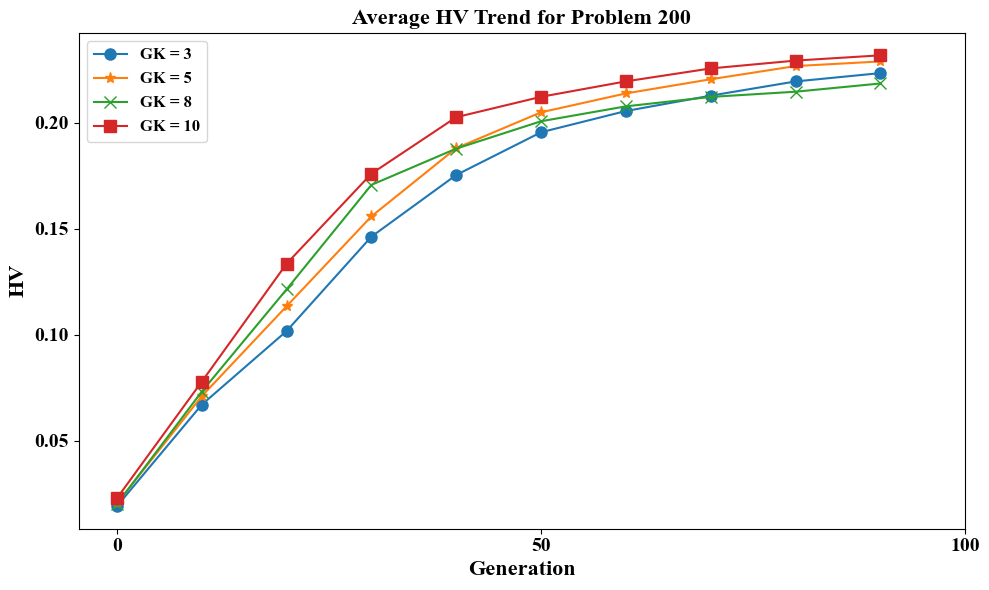

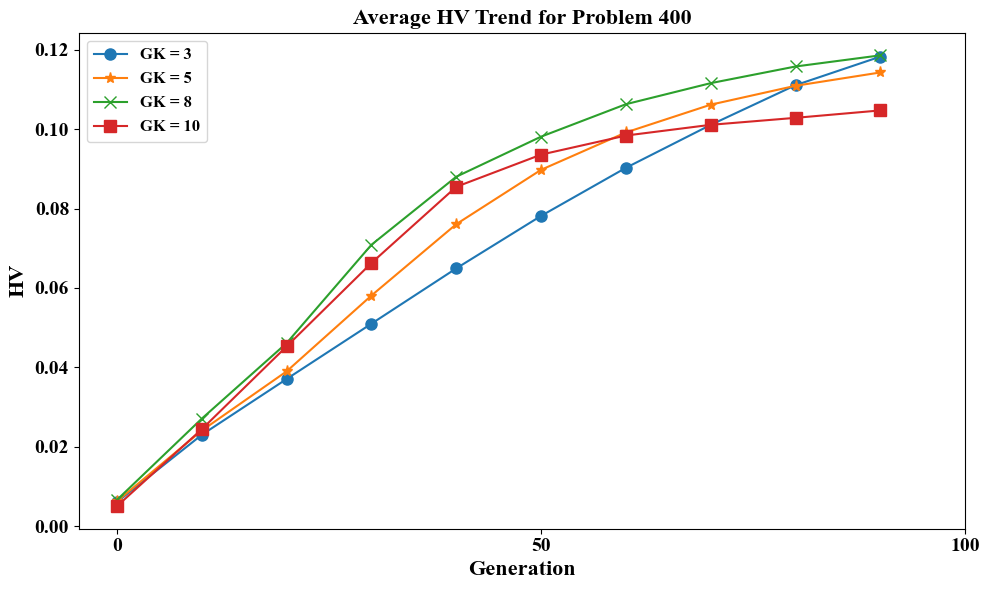

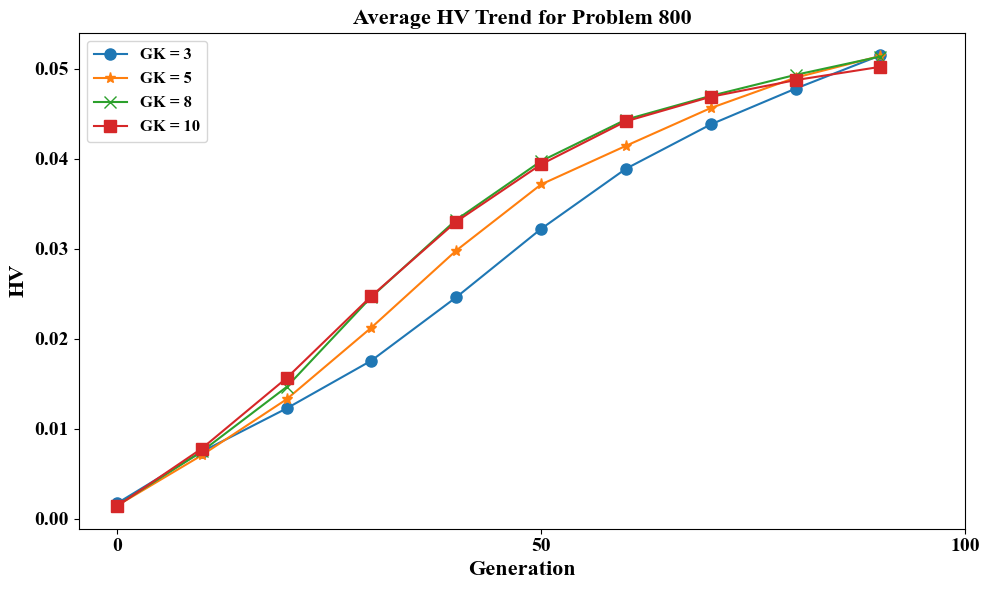

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set the global font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Define base path where CSV files are located
base_path = "F:/setup files/downloads/Finetune/"

# Settings
problem_types = [200, 400, 800]
params_list = [3, 5, 8, 10]
markers = ['o', '*', 'x', 's']  # One marker per param

# Dots to plot
dot_generations = list(range(0, 100, 10))

for problem_type in problem_types:
    plt.figure(figsize=(10, 6))

    for param, marker in zip(params_list, markers):
        csv_filename = os.path.join(base_path, f"Avg_HV_Trends_Type_{problem_type // 100}_param_{param}.csv")
        
        if not os.path.exists(csv_filename):
            print(f"File not found: {csv_filename}")
            continue
        
        df_avg_hv = pd.read_csv(csv_filename, index_col='Generation')

        # Ensure all required dots are present
        gen_to_plot = [g for g in dot_generations if g in df_avg_hv.index]

        if not gen_to_plot:
            continue
        
        hv_values = df_avg_hv.loc[gen_to_plot, 'Proposed'].values
        plt.plot(gen_to_plot, hv_values, marker=marker, linestyle='-', label=f'GK = {param}', markersize=8)

    # Axis labels and aesthetics
    plt.xlabel('Generation', fontsize=16, fontweight='bold')
    plt.ylabel('HV', fontsize=16, fontweight='bold')
    plt.xticks([0, 50, 100], fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.grid(False)
    plt.title(f'Average HV Trend for Problem {problem_type}', fontsize=16, fontweight='bold')

    # Legend
    plt.legend(prop={'weight': 'bold', 'size': 12})

    # Save or show
    pdf_filename = os.path.join(base_path, f"HV_Convergence_{problem_type}.pdf")
    plt.savefig(pdf_filename, format='pdf')

    plt.tight_layout()
    plt.show()


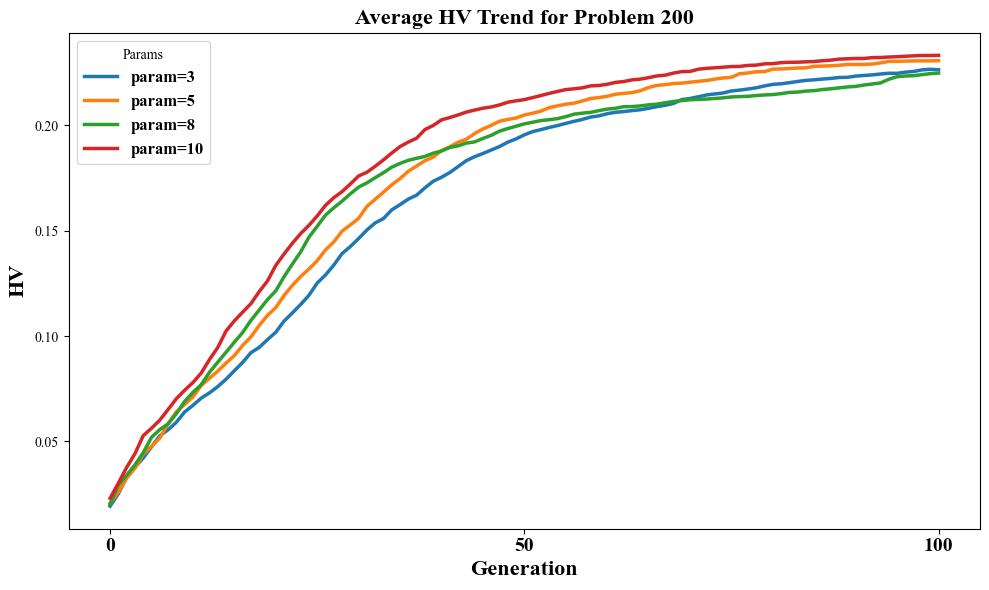

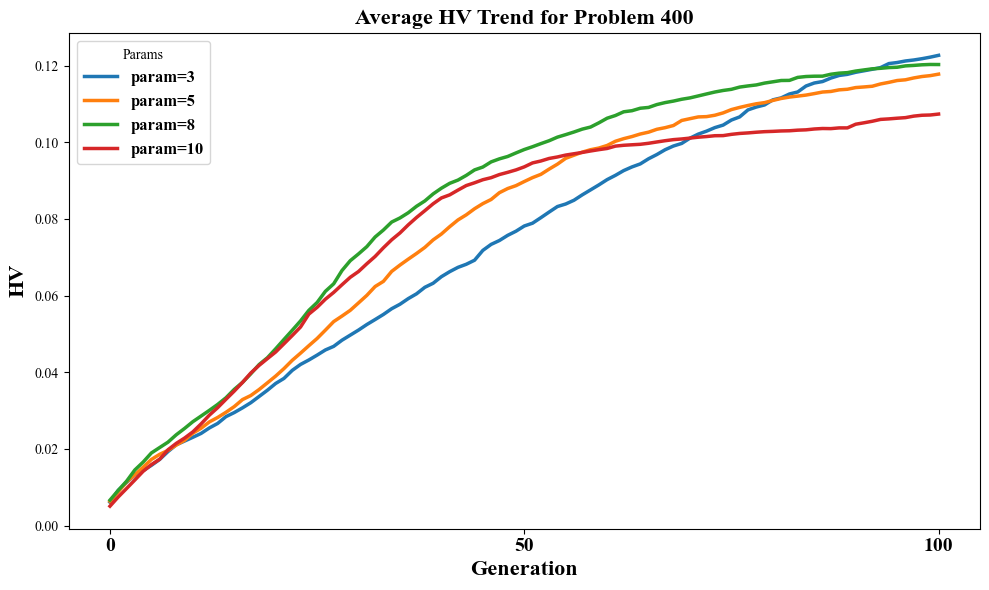

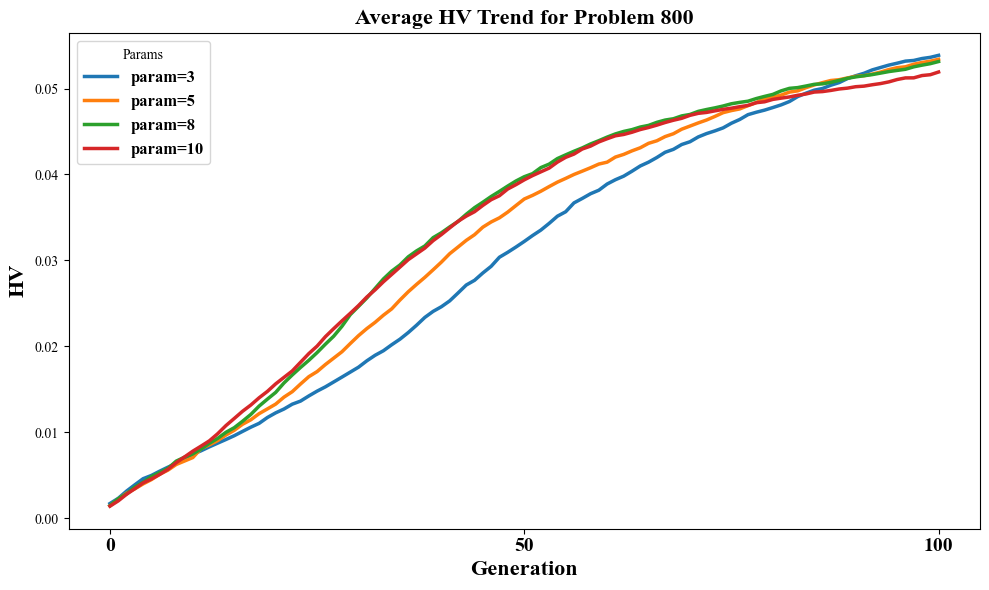

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set the global font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Define base path where CSV files are located
base_path = "F:/setup files/downloads/Finetune/"

# Settings
problem_types = [200, 400, 800]
params_list = [3, 5, 8, 10]

for problem_type in problem_types:
    plt.figure(figsize=(10, 6))

    for param in params_list:
        csv_filename = os.path.join(base_path, f"Avg_HV_Trends_Type_{problem_type // 100}_param_{param}.csv")
        
        # Check if file exists to avoid errors
        if not os.path.exists(csv_filename):
            print(f"File not found: {csv_filename}")
            continue
        
        df_avg_hv = pd.read_csv(csv_filename, index_col='Generation')

        # Plot 'Proposed' algorithm for current param
        generations = df_avg_hv.index.values
        hv_values = df_avg_hv['Proposed'].values
        plt.plot(generations, hv_values, label=f'param={param}', linewidth=2.5)

    # Labeling and aesthetics
    plt.xlabel('Generation', fontsize=16, fontweight='bold')
    plt.ylabel('HV', fontsize=16, fontweight='bold')
    plt.xticks([0, 50, 100], fontsize=14, fontweight='bold')
    # plt.yticks(fontsize=14, fontweight='bold')
    plt.grid(False)
    plt.title(f'Average HV Trend for Problem {problem_type}', fontsize=16, fontweight='bold')

    # Add legend
    plt.legend(title='Params', prop={'weight': 'bold', 'size': 12})

    # Save or show
    # pdf_filename = os.path.join(base_path, f"HV_Convergence_{problem_type}.pdf")
    # plt.savefig(pdf_filename, format='pdf')
    
    plt.tight_layout()
    plt.show()
